In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [2]:
# constants used in pre-processing

TEMP_MEAN = 0
TEMP_STD = 0

PRESS_MEAN = 0
PRESS_STD = 0
PRESS_DEFAULT = 1000

HUMIDITY_MEAN = 0
HUMIDITY_STD = 0

TIME_ZERO = pd.Timestamp('1970-01-01 00:00:00')
TIME_DELTA = '1h'

SEQ_LENGTH = 48
TO_PREDICT = 24
PERIOD_TO_PREDICT = 1

In [9]:
 # functions for cleaning the data

def preprocess_data(data, val_pct=0.2):
    
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    
    pct = data.index[-(int(val_pct * len(data)))]
    
    print("pct:", pct, "data.index[0]:", data.index[0], "data.index[-1]:", data.index[-1], "len(data):", len(data))
    
    prev_days_x = deque(maxlen=SEQ_LENGTH)
    prev_days_y = deque(maxlen=SEQ_LENGTH)
    
    for index, row in zip(data.index, data.values):
        if index > data.index[-2*PERIOD_TO_PREDICT]:
            break
        prev_days_x.append([])
        prev_days_y.append([])
        for n in range(len(row)):
            if (n < len(row) / 2):
                if type(row[n]) is not tuple:
                    prev_days_x[len(prev_days_x) - 1].append(row[n])
#                 else:
#                     prev_days_x[len(prev_days_x) - 1].extend(row[n])
            else:
                if type(row[n]) is not tuple:
                    prev_days_y[len(prev_days_y) - 1].append(row[n])
#                 else:
#                     prev_days_y[len(prev_days_y) - 1].extend(row[n])
                
        if len(prev_days_x) == SEQ_LENGTH:
#             if (rand.rand() < val_pct) TODO! RANDOM SPLIT
            if index < pct:
                train_x.append(np.array(prev_days_x))
                train_y.append(np.array(prev_days_y[-1]))
            else:
                val_x.append(np.array(prev_days_x))
                val_y.append(np.array(prev_days_y[-1]))
    
    # shuffling the data
    rng_state = np.random.get_state()
    np.random.shuffle(train_x)
    np.random.set_state(rng_state)
    np.random.shuffle(train_y)
        
    return (np.array(train_x), np.array(train_y)), (np.array(val_x), np.array(val_y))


def get_labels(data):
    """ returns the list of distinct labels in given data column """
    labels = list(set(data))
    return labels
    

def data_to_dicts(labels):
    """ returns pair of data to one-hot and one-hot to data dictionaries """
    data_to_oh = {x:tuple(1 if y == labels.index(x) else 0 
                    for y in range(len(labels))) 
                    for x in labels}
    
    oh_to_data = {y:x for x, y in data_to_oh.items()}
    
    return data_to_oh, oh_to_data


# ======= temp =======

def normalize_temp(temp):
    global TEMP_MEAN, TEMP_STD
    TEMP_MEAN = temp.mean()
    TEMP_STD = temp.std()
    return [(t - TEMP_MEAN) / TEMP_STD for t in temp]


def denormalize_temp(temp):
    return [t * TEMP_STD + TEMP_MEAN for t in temp]


def denormalize_temp_single(temp):
    return temp * TEMP_STD + TEMP_MEAN


# ======= press =======

def normalize_press(press):
    
    # 0's mess up mean and std calculations
    press = press.replace(0, PRESS_DEFAULT)
    
    global PRESS_MEAN, PRESS_STD
    PRESS_MEAN = press.mean()
    PRESS_STD = press.std()
#     for i in range(len(press)):
#         if press[i] == 0:
#             press[i] = press[i-1] if i != 0 else PRESS_DEFAULT

    return [(PRESS_DEFAULT - PRESS_MEAN) / PRESS_STD if p == 0 else (p - PRESS_MEAN) / PRESS_STD for p in press]


def denormalize_press(press):
    return [p * PRESS_STD + PRESS_MEAN for p in press]


def denormalize_press_single(press):
    return press * PRESS_STD + PRESS_MEAN


# ======= hum =======

def normalize_humidity(hum):
    global HUMIDITY_MEAN, HUMIDITY_STD
    HUMIDITY_MEAN = hum.mean()
    HUMIDITY_STD = hum.std()
    return [(h - HUMIDITY_MEAN) / HUMIDITY_STD for h in hum]


def denormalize_humidity(hum):
    return [h * HUMIDITY_STD + HUMIDITY_MEAN for h in hum]


def denormalize_humidity_single(hum):
    return hum * HUMIDITY_STD + HUMIDITY_MEAN

# ===================

def normalize_time(times):
    """ converts date-time data column to a UNIX-style int (number of TIME_DELTA steps since TIME_ZERO) """
    times = [pd.Timestamp(time[:-6]) for time in times]
    times = [((time - TIME_ZERO) // pd.Timedelta(TIME_DELTA)) for time in times]
    return times


# def denormalize_time(time):
# TODO


def one_hot_encode(data, data_to_oh):
    return [data_to_oh[d] for d in data]


def one_hot_decode(oh, oh_to_data):
    return [oh_to_data[o] for o in oh]

In [10]:
df = pd.read_csv("weatherHistory.csv", names = ['time', 'summary', 'precip', 'temp', 'app_temp', 'humidity', 'wind_speed', 'wind_bearing', 'visibility', 'loud_cover', 'pressure', 'daily_summary'], low_memory=False)

df = df.drop([0])
df = df.drop(['app_temp', 'wind_speed', 'wind_bearing', 'visibility', 'loud_cover', 'daily_summary'], axis=1) # TODO add wind_speed and other usefull data

df = df.drop(['summary', 'precip'], axis=1)

df.set_index('time', inplace=True)
df.index = normalize_time(df.index)

df = df.astype('float32')
print(df.columns.values)

['temp' 'humidity' 'pressure']


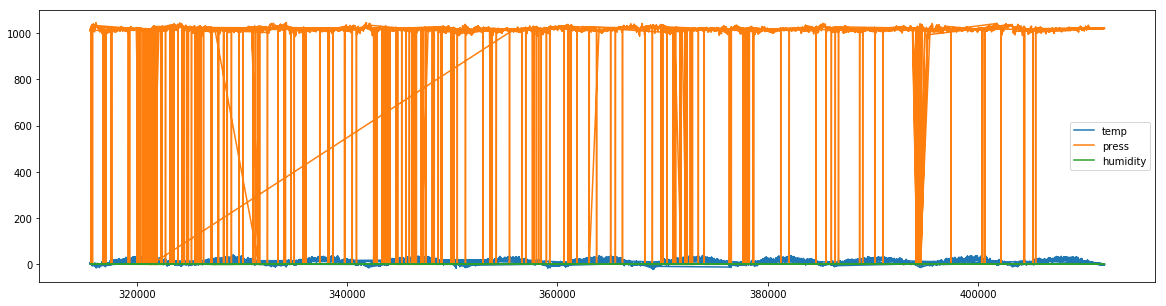

In [11]:
plt.figure(figsize=(20, 5))
plt.plot(df['temp'], label="temp")
plt.plot(df['pressure'], label="press")
plt.plot(df['humidity'], label="humidity")
plt.legend()
plt.show()

In [12]:
# summary_labels = get_labels(df['summary'])
# print("len(summary_labels):", len(summary_labels))

# our training data contains nans when there is no precipitation
# df['precip'] = df['precip'].fillna("clear")
# precip_labels = get_labels(df['precip'])
# print("len(precip_labels):", len(precip_labels))

# daily_summary_labels = get_labels(df['daily_summary'])
# print("len(daily_summary_labels):", len(daily_summary_labels))


# summary_to_oh, oh_to_summary = data_to_dicts(summary_labels)
# precip_to_oh, oh_to_precip = data_to_dicts(precip_labels)

# print(summary_to_oh, oh_to_summary, sep='\n\n')
# print(precip_to_oh, oh_to_precip, sep='\n\n')

# df['summary'] = one_hot_encode(df['summary'], summary_to_oh)
# df['summary'].head()
# df['precip'] = one_hot_encode(df['precip'], precip_to_oh)
# df['precip'].head()

In [13]:
df['temp'] = normalize_temp(df['temp'])
df['pressure'] = normalize_press(df['pressure'])
df['humidity'] = normalize_humidity(df['humidity'])
# df['humidity'] = df['humidity'].apply(pd.to_numeric)

print("temperature: mean={}, std={}".format(TEMP_MEAN, TEMP_STD))
print("pressure: mean={}, std={}".format(PRESS_MEAN, PRESS_STD))
print("humidity: mean={}, std={}".format(HUMIDITY_MEAN, HUMIDITY_STD))

# print(denormalize_temp(df['temp'])[:5])
# print(denormalize_press(df['pressure'])[:5])
# print(min(df['temp']), max(df['temp']), '\n', min(df['pressure']), max(df['pressure']))

temperature: mean=11.93267822265625, std=9.551546096801758
pressure: mean=1016.5895385742188, std=7.963654041290283
humidity: mean=0.7348989248275757, std=0.19547273218631744


In [16]:
# sorting data by index
df = df.sort_index()

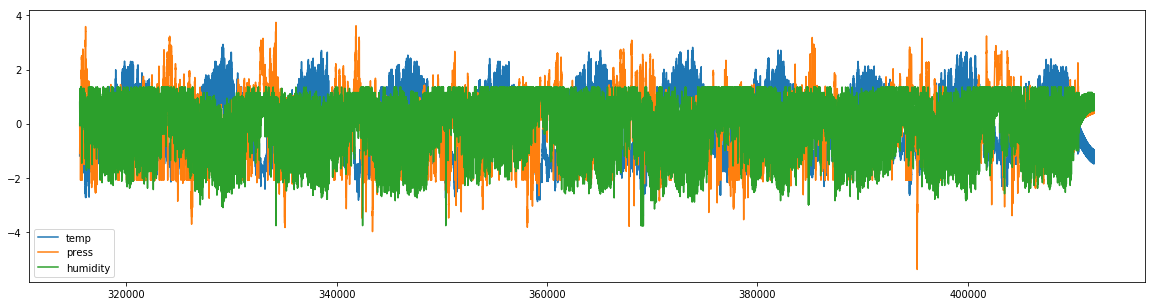

In [17]:
plt.figure(figsize=(20, 5))
plt.plot(df['temp'], label="temp")
plt.plot(df['pressure'], label="press")
plt.plot(df['humidity'], label="humidity")
plt.legend()
plt.show()

In [18]:
# we shift values so that each row has a corresponding future row
for col in df.columns:
    df["future_{}".format(col)] = df["{}".format(col)].shift(-PERIOD_TO_PREDICT)

In [19]:
%%time
df = df.loc[:410500];
(train_x, train_y), (val_x, val_y) = preprocess_data(df, 0.3)

print("length of train x:", len(train_x))
print("length of train y:", len(train_y))
print("length of val x:", len(val_x))
print("length of val y:", len(val_y))
print("ratio:", len(val_x) / (len(train_x) + len(val_x)))

pct: 382016 data.index[0]: 315576 data.index[-1]: 410500 len(data): 94946
length of train x: 66416
length of train y: 66416
length of val x: 28482
length of val y: 28482
ratio: 0.30013277413644124
Wall time: 5.97 s


# Model

In [20]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(66416, 48, 3)
(66416, 3)
(28482, 48, 3)
(28482, 3)


In [63]:
# constants used in the model

LSTM_LAYERS = 1
LSTM_UNITS = 128

FC_LAYERS = 1
FC_UNITS = 128

# INPUT_DIM = (len(summary_labels) + len(precip_labels) + 3) * SEQ_LENGTH
INPUT_DIM = 3 * SEQ_LENGTH
# OUTPUT_DIM = 3 * SEQ_LENGTH
OUTPUT_DIM = 3

BATCH_SIZE = 128

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, CuDNNLSTM, Dropout
# import time

# NAME = "weater_forecaster_{}".format(int(time.time()))
# tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

model = Sequential()

for i in range(LSTM_LAYERS):
    if i == 0:
        if i != LSTM_LAYERS - 1:
            model.add(CuDNNLSTM(LSTM_UNITS, input_shape=(train_x.shape[1:]), return_sequences=True))
        else:
            model.add(CuDNNLSTM(LSTM_UNITS, input_shape=(train_x.shape[1:]), return_sequences=False))
    else:
        if i != LSTM_LAYERS - 1:
            model.add(CuDNNLSTM(LSTM_UNITS, return_sequences=True))
        else:
            model.add(CuDNNLSTM(LSTM_UNITS, return_sequences=False))
    model.add(Dropout(0.5))
for i in range(FC_LAYERS):
    model.add(Dense(FC_UNITS, activation='tanh'))

model.add(Dense(OUTPUT_DIM, activation='linear'))
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=50, batch_size=BATCH_SIZE, validation_data=(val_x, val_y))
# model.fit(train_x, new_train_y, epochs = 20, batch_size=32, validation_data=(val_x, new_val_y), callbacks=[tensorboard])


Train on 66416 samples, validate on 28482 samples
Epoch 1/50
66416/66416 [==============================] - 7s 109us/step - loss: 0.2099 - acc: 0.8865 - val_loss: 0.1262 - val_acc: 0.9169
Epoch 2/50
66416/66416 [==============================] - 6s 90us/step - loss: 0.1863 - acc: 0.8992 - val_loss: 0.1199 - val_acc: 0.9206
Epoch 3/50
66416/66416 [==============================] - 6s 90us/step - loss: 0.1826 - acc: 0.9019 - val_loss: 0.1166 - val_acc: 0.9212
Epoch 4/50
66416/66416 [==============================] - 6s 90us/step - loss: 0.1799 - acc: 0.9005 - val_loss: 0.1194 - val_acc: 0.9216
Epoch 5/50
66416/66416 [==============================] - 6s 90us/step - loss: 0.1773 - acc: 0.9027 - val_loss: 0.1167 - val_acc: 0.9230
Epoch 6/50
66416/66416 [==============================] - 6s 96us/step - loss: 0.1747 - acc: 0.9030 - val_loss: 0.1159 - val_acc: 0.9244
Epoch 7/50
66416/66416 [==============================] - 6s 97us/step - loss: 0.1713 - acc: 0.9041 - val_loss: 0.1145 - val_ac

In [81]:
# === HYBRID ===

test_length = 1000
test_index = 0

def append_to_end(x, val):
    for i in range(len(x) - 1):
        x[i] = x[i + 1]
    x[-1] = val
        
output1 = model.predict(val_x)
output2 = []
for i in range(int(test_length / TO_PREDICT)):
    x = np.copy(val_x[i * TO_PREDICT])
    for j in range(TO_PREDICT):
        output2.append(model.predict(x.reshape(-1, 48, 3)).reshape(3,))
        append_to_end(x, output2[-1])

In [82]:
# === SLIDING WINDOW ===

# test_length = 1000
# test_index = 0

# def append_to_end(x, val):
#     for i in range(len(x) - 1):
#         x[i] = x[i + 1]
#     x[-1] = val
        
# output1 = model.predict(val_x)
# output2 = []
# x = np.copy(val_x[0])
# print(x.shape)
# for i in range(test_length):
#     output2.append(model.predict(x.reshape(-1, 48, 3)).reshape(3,))
#     append_to_end(x, output2[-1])

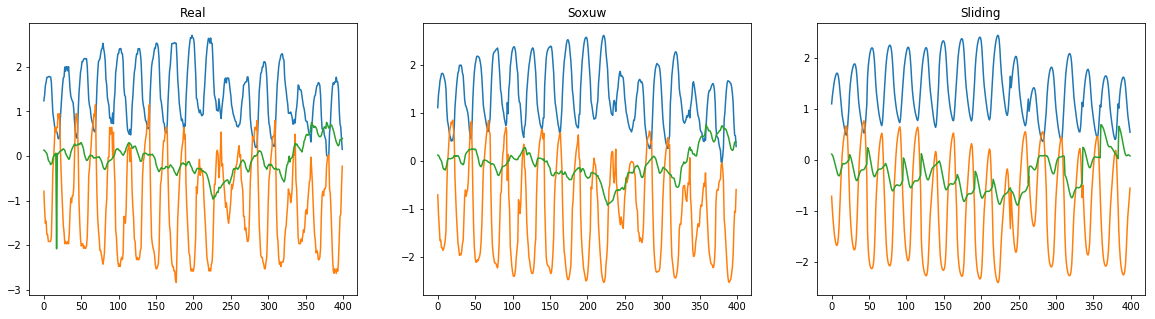

In [83]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(val_y[:400])
plt.title("Real")
# plt.ylim(0, 1)

plt.subplot(1, 3, 2)
plt.plot(output1[:400])
plt.title("Soxuw")
# plt.ylim(0, 1)

plt.subplot(1, 3, 3)
plt.plot(output2[:400])
plt.title("Sliding")
# plt.ylim(0, 1)

plt.show()

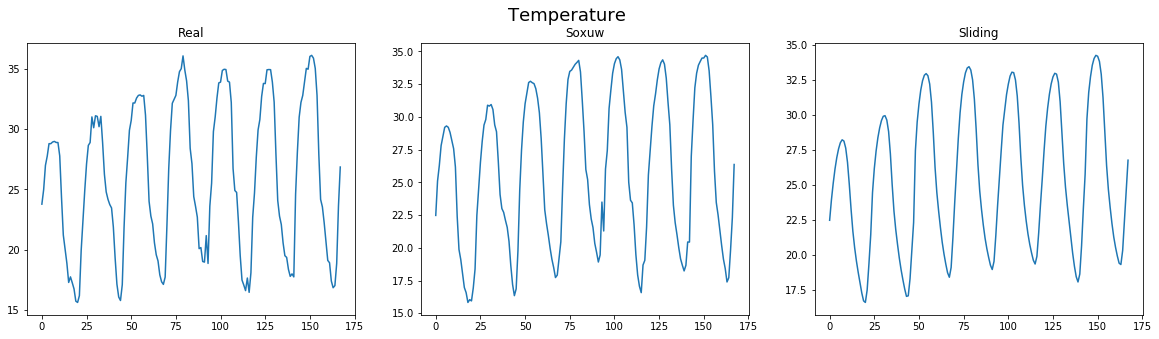

In [84]:
# print(val_y.shape)
real_temp = []
output_temp1 = []
output_temp2 = []

temp_size = 24*7

# for val in val_y[:400]:
#     real_temp.append(val[0] * TEMP_COEF)
    
# for val in output1[:400]:
#     output_temp1.append(val[0] * TEMP_COEF)
    
# for val in output2[:400]:
#     output_temp2.append(val[0] * TEMP_COEF)


for val in val_y[:temp_size]:
    real_temp.append(denormalize_temp_single(val[0]))
    
for val in output1[:temp_size]:
    output_temp1.append(denormalize_temp_single(val[0]))
    
for val in output2[:temp_size]:
    output_temp2.append(denormalize_temp_single(val[0]))


plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(real_temp)
plt.title("Real")

plt.subplot(1, 3, 2)
plt.plot(output_temp1)
plt.title("Soxuw")

plt.subplot(1, 3, 3)
plt.plot(output_temp2)
plt.title("Sliding")

plt.suptitle("Temperature", fontsize=18)
plt.show()

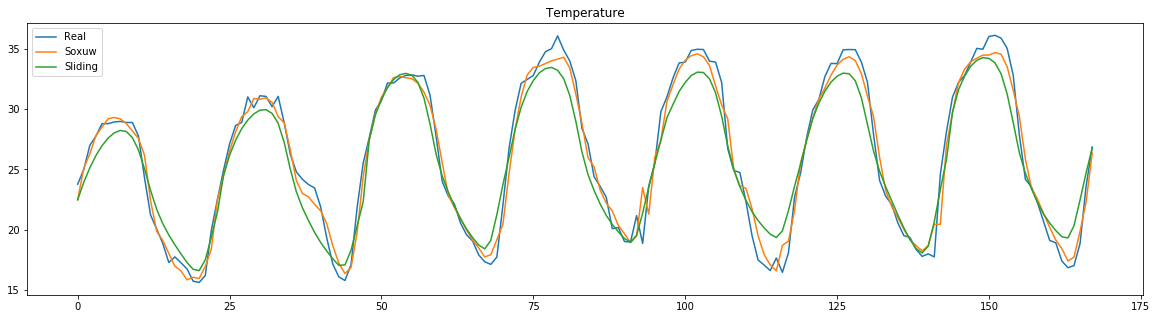

In [85]:
plt.figure(figsize=(20, 5))

plt.plot(real_temp, label="Real")

plt.plot(output_temp1, label="Soxuw")

plt.plot(output_temp2, label="Sliding")

plt.title("Temperature")
plt.legend(loc='upper left')
plt.show()

In [34]:
# hm_epochs = 1
# rnn_size = 128

# tf.reset_default_graph()

# x = tf.placeholder(tf.float32, [None, SEQ_LENGTH, num_features])
# y = tf.placeholder(tf.float32, [None, num_features])

# def recurrent_neural_network(x):
#     layer = {'weights':tf.Variable(tf.random_normal([rnn_size, num_features])),
#              'biases':tf.Variable(tf.random_normal([num_features]))}

#     x = tf.transpose(x, [1, 0, 2])
#     x = tf.reshape(x, [-1, num_features])
#     x = tf.split(x, SEQ_LENGTH, 0)

#     lstm_cell = tf.nn.rnn_cell.LSTMCell(rnn_size, state_is_tuple=True)
#     outputs, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

#     output = tf.matmul(outputs[-1], layer['weights']) + layer['biases']

#     return output


# def train_neural_network(x):
#     prediction = recurrent_neural_network(x)
#     cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y) )
#     optimizer = tf.train.AdamOptimizer().minimize(cost)
    
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())

#         for epoch in range(hm_epochs):
#             epoch_loss = 0
# #             for _ in range(int(mnist.train.num_examples/batch_size)):
#             for i in range(int(len(train_x)/batch_size)):
# #                 epoch_x, epoch_y = mnist.train.next_batch(batch_size)
#                 epoch_x = train_x[i * batch_size:(i + 1) * batch_size]
#                 epoch_y = train_y[i * batch_size:(i + 1) * batch_size]
# #                 epoch_x = epoch_x.reshape((batch_size,n_chunks,chunk_size))

#                 _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
#                 epoch_loss += c

#             print('Epoch', epoch + 1, 'completed out of', hm_epochs,'loss:', epoch_loss)

# #         correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

# #         accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
#         accuracy, _ = tf.metrics.mean_squared_error(labels=y, predictions=prediction)
# #         print('Accuracy:',accuracy.eval({x:mnist.test.images.reshape((-1, n_chunks, chunk_size)), y:mnist.test.labels}))
# #         print('Accuracy:',accuracy.eval({x:val_x, y:val_y}))
#         print('Accuracy:', sess.run(accuracy, feed_dict={x: val_x, y: val_y}))

# train_neural_network(x)